In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## MNIST

In [2]:
#Fetches the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
some_digit = X[0]
#Reshape some_digit to 28x28 array
some_digit_image = some_digit.reshape(28, 28)

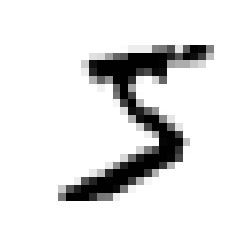

In [7]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

In [9]:
#Convert label from string to number
y = y.astype(np.uint8)

In [10]:
#Create training set and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
#Create target vectors
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## Training a Binary Classifier

In [12]:
#Create an SGD classifier
from sklearn.linear_model import SGDClassifier #Stochasitc Gradient Descent
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([False])

## Measuing Accuracy Using Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
#Cross-validation alternative implimentation
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct= sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9532
0.95125
0.9625


In [ ]:
from sklearn.model_selection import cross_val_score
#Cross-validation using sklearn's cross_val_score() function
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9532 , 0.95125, 0.9625 ])

In [ ]:
from sklearn.base import BaseEstimator
#Dumb classifier
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
#Confusion Matrix
y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[52992,  1587],
       [ 1074,  4347]])

## Precision and Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred)

0.7325581395348837

In [ ]:
recall_score(y_train_5, y_train_pred)

0.8018815716657444

In [ ]:
f1_score(y_train_5, y_train_pred)

0.765653896961691

## Precision/Recall Trade-off

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label="recall")

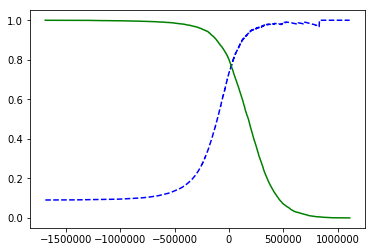

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.5993359158826784

## The ROC Curve

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')

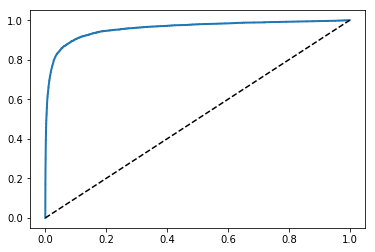

In [ ]:
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9584692857783504

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Use a random forest classifier
forest_clf = RandomForestClassifier(random_state=44)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

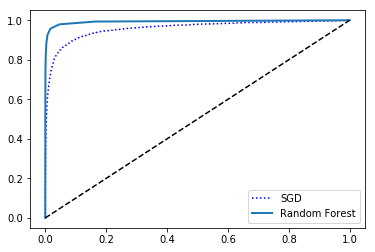

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.993049774142945

## Multiclass Classification

In [ ]:
#Use a Support Vector Machine classifier
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_Clf.predict([some_digit])